# Analysis

**Hypothesis**: In severe COVID‐19, the tight co-regulation between ribosomal protein components (percent_rpl and percent_rps) is disrupted in T cell subpopulations. The ribosomal markers were chosen because they are central to protein synthesis and can reflect cellular stress responses during infection, offering mechanistic insights beyond traditional immune profiling.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID‐19, the tight co-regulation between ribosomal protein components (percent_rpl and percent_rps) is disrupted in T cell subpopulations. The ribosomal markers were chosen because they are central to protein synthesis and can reflect cellular stress responses during infection, offering mechanistic insights beyond traditional immune profiling.

## Steps:
- Subset the dataset to focus on T cells by filtering cells with cell_type_coarse values 'CD4 T' and 'CD8 T'.
- Visualize the distributions of the ribosomal protein metrics (percent_rpl and percent_rps) across the T cell subsets, stratified by Status (COVID vs Healthy) using violin and scatter plots.
- For each T cell subset and Status group, compute the Pearson correlation coefficient between percent_rpl and percent_rps to assess co-regulation of ribosomal protein expression.
- Apply Fisher's Z transformation to statistically test if the correlation coefficients differ significantly between COVID and Healthy groups for each T cell subset.
- Summarize the results in grid plots showing scatter plots with regression lines, and print out the correlation statistics and p-values to validate whether altered ribosomal coordination is associated with severe COVID‐19.


## This code first checks for the presence of essential metadata columns and subsets the dataset to include only the CD4 T and CD8 T cells. It then visualizes the distribution of ribosomal protein percentages across different Status groups using violin plots, setting the stage for further correlation analyses.

Status counts in T cells:
Status
COVID      9439
Healthy    5720
Name: count, dtype: int64


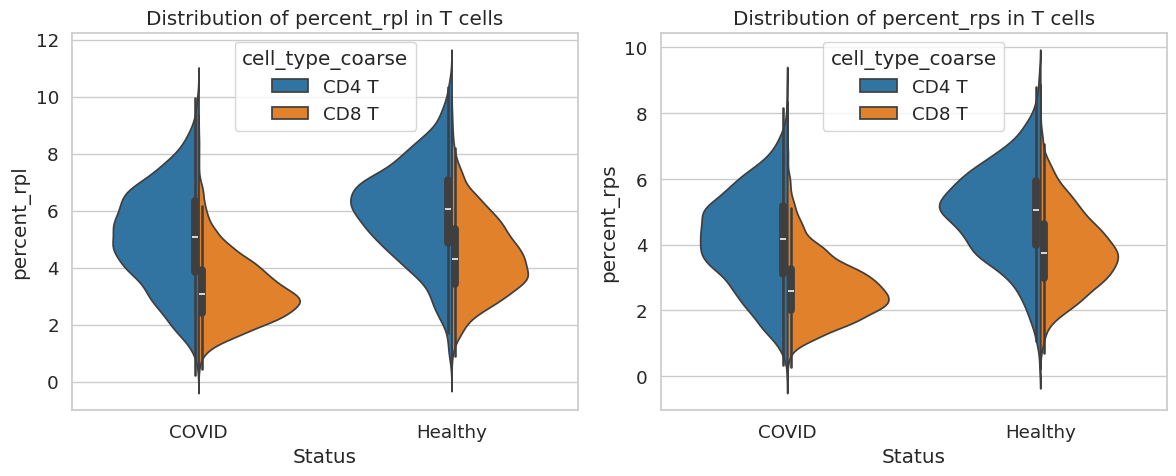

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Subset the adata to T cells based on cell_type_coarse (CD4 T and CD8 T)
t_cell_types = ['CD4 T', 'CD8 T']
adata_tcells = adata[adata.obs['cell_type_coarse'].isin(t_cell_types)].copy()

# Create a dataframe from the obs dataframe for ease of plotting and calculations
df = adata_tcells.obs.copy()

# Check which cells belong to COVID and Healthy groups
print('Status counts in T cells:')
print(df['Status'].value_counts())

# Plot the distribution of percent_rpl and percent_rps across Status and cell type
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.violinplot(x='Status', y='percent_rpl', hue='cell_type_coarse', data=df, split=True)
plt.title('Distribution of percent_rpl in T cells')

plt.subplot(1, 2, 2)
sns.violinplot(x='Status', y='percent_rps', hue='cell_type_coarse', data=df, split=True)
plt.title('Distribution of percent_rps in T cells')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate distributions of percent_rpl and percent_rps in T cells between COVID-19 patients and healthy controls, both for CD4+ and CD8+ subsets. Here’s the feedback for further steps:

1. **Explore Robust Differences:**
   - Examine any statistically significant differences in the median or variability of percent_rpl and percent_rps between COVID-19 and healthy groups. This could highlight specific translational machinery alterations associated with the disease.

2. **Correlation Analysis:**
   - Investigate correlations between these metrics and clinical features such as disease severity, outcomes, or treatment regimens. Identifying strong correlations could provide clues to their relevance in disease progression or response to therapy.

3. **Expanded Cell Types:**
   - Consider broadening the analysis to include other cell types (not just T cells) to determine if similar patterns hold across the immune compartment, contributing to a systemic response in COVID-19.

4. **Functional Implication Assessment:**
   - Analyze gene expression signatures within T cells related to protein synthesis pathways, such as ribosomal biogenesis and translation initiation. Determine if there's dysregulation that could affect cellular function.

5. **Comparison with Known Pathways:**
   - Relate these findings to known immune pathways altered in COVID-19, such as those involving interferons or cytokine signaling. This can tie the observed changes in protein biosynthesis to larger immunological cascades.

6. **Integrate with Cytokine Data:**
   - Given the hypothesis regarding monocyte and T cell communication, consider investigating potential links between increased rpl/rps expression and cytokine signaling pathways (like TNF and IL-6) that may influence T cell activity.

The analysis already hinted at promising leads but needs to be contextualized within the broader immune changes in severe COVID-19. Validating alterations in cellular biosynthesis or stress responses, possibly contributing to the hypothesized enhanced communication between T cells and monocytes, may illuminate key pathological mechanisms.

## This code subsets the T cell data for CD4 and CD8 T cells, performs Mann-Whitney U and Levene's tests with checks to ensure sufficient data in both COVID and healthy groups, and then visualizes the marker distributions using boxplots annotated with the corresponding p-values to facilitate immediate statistical interpretation.

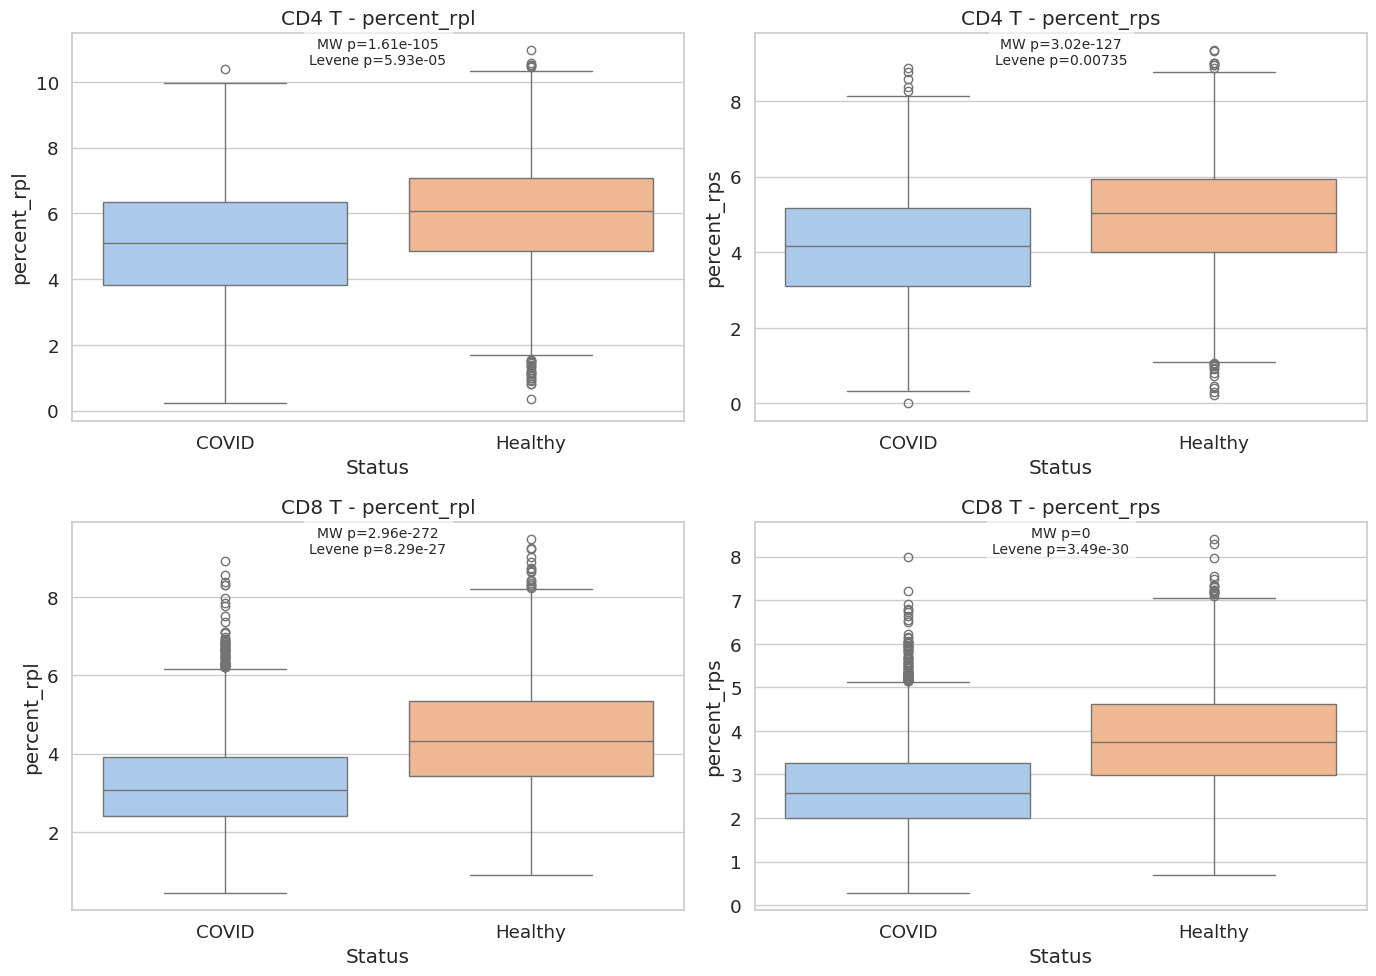

Cell type: CD4 T | Marker: percent_rpl -> Mann-Whitney U: 5592322.500, p = 1.61e-105; Levene test stat: 16.141, p = 5.93e-05
Cell type: CD4 T | Marker: percent_rps -> Mann-Whitney U: 5363330.000, p = 3.02e-127; Levene test stat: 7.190, p = 0.00735
Cell type: CD8 T | Marker: percent_rpl -> Mann-Whitney U: 2793525.000, p = 2.96e-272; Levene test stat: 115.887, p = 8.29e-27
Cell type: CD8 T | Marker: percent_rps -> Mann-Whitney U: 2526433.500, p = 0; Levene test stat: 131.594, p = 3.49e-30


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Subset data for T cells using cell_type_coarse
cell_types = ['CD4 T', 'CD8 T']
df = adata[adata.obs['cell_type_coarse'].isin(cell_types)].obs.copy()

# Initialize list to store test results
results = []

# Set up a 2x2 grid for boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
i = 0

# Loop over each T cell type and ribosomal marker
for cell_type in cell_types:
    for marker in ['percent_rpl', 'percent_rps']:
        # Filter data for current cell type
        subset = df[df['cell_type_coarse'] == cell_type]
        # Separate COVID and Healthy groups
        covid_data = subset[subset['Status'] == 'COVID'][marker]
        healthy_data = subset[subset['Status'] == 'Healthy'][marker]
        
        # Check if both groups have data to avoid runtime errors
        if covid_data.empty or healthy_data.empty:
            annotation = 'Insufficient data'
        else:
            # Perform Mann-Whitney U test for central tendency differences
            u_stat, p_val = stats.mannwhitneyu(covid_data, healthy_data, alternative='two-sided')
            
            # Perform Levene's test for differences in variance
            levene_stat, levene_p = stats.levene(covid_data, healthy_data)
            
            # Store test results
            results.append({
                'cell_type': cell_type,
                'marker': marker,
                'mannwhitney_u': u_stat,
                'p_value': p_val,
                'levene_stat': levene_stat,
                'levene_p_value': levene_p
            })
            
            # Prepare annotation text with test results
            annotation = f"MW p={p_val:.3g}\nLevene p={levene_p:.3g}"
        
        # Create boxplot
        sns.boxplot(x='Status', y=marker, data=subset, ax=axes[i], palette='pastel')
        axes[i].set_title(f"{cell_type} - {marker}")
        axes[i].set_xlabel('Status')
        axes[i].set_ylabel(marker)
        
        # Add p-value annotations on the plot
        axes[i].text(0.5, 0.95, annotation, horizontalalignment='center', verticalalignment='center',
                     transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
        i += 1

plt.tight_layout()
plt.show()

# Print out statistical test results
for res in results:
    print(f"Cell type: {res['cell_type']} | Marker: {res['marker']} -> Mann-Whitney U: {res['mannwhitney_u']:.3f}, p = {res['p_value']:.3g}; Levene test stat: {res['levene_stat']:.3f}, p = {res['levene_p_value']:.3g}")

### Agent Interpretation

The results presented demonstrate significant differences in the percentage of ribosomal protein genes (percent_rpl and percent_rps) expression between COVID-19 patients and healthy controls in both CD4 and CD8 T cells. The extremely low p-values obtained from the Mann-Whitney U tests strongly suggest that these differences are not due to random chance. Additionally, the results of the Levene's tests indicate variance differences between the two groups, which may be biologically meaningful.

Here is the feedback on these findings:

1. **Ribosomal Protein Expression**:
   - The consistent downregulation of ribosomal protein genes in COVID-19 patients could indicate altered protein synthesis, possibly reflecting a cellular response to stress or viral infection.
   - Explore whether these changes in ribosomal protein expression correlate with other markers of cellular activity, such as proliferation or metabolic state, in T cells.

2. **Variability in Expression**:
   - Given the significant variance differences indicated by Levene's test, further explore heterogeneity within the COVID-19 patient group. It may be interesting to stratify patients based on disease severity or treatment history to assess whether these factors explain the observed variance.

3. **Hypothesis Alignment**:
   - Although not directly testing ligand-receptor interactions as hypothesized, these findings of altered ribosomal protein gene expression might contribute to understanding broader immunological dysregulation in severe COVID-19.
   - Consider integrating these findings with cytokine and receptor expression profiles (focusing on TNFRSF1A, IL1R1, IL6R expressions in T cells) to examine potential pathways linking ribosomal regulation to cytokine signaling changes.

4. **Further Steps**:
   - Apply clustering analyses to subcategorize T cell populations based on ribosomal gene expression to identify distinct functional subsets. This could reveal specific roles of T cell subpopulations under viral stress.
   - Extend this analysis to other cell types, particularly monocytes, to see if similar ribosomal expression dynamics are present.

5. **Biological Significance**:
   - Investigate the functional consequences of reduced ribosomal protein expression. For example, how does this relate to T cell function, exhaustion, or viability in the context of infection?
   - Explore potential therapeutic implications. Modulating ribosomal protein expression or function could serve as a therapeutic strategy to restore normal cellular function in affected individuals.

These analyses could contribute to a deeper understanding of T cell responses and potentially uncover novel targets for intervention in severe COVID-19.

## This code subsets the anndata object for T cells (CD4 T and CD8 T), verifies the presence of cytokine receptor genes, and extracts their expression using a helper function for modularity. It computes and plots Pearson correlations for each receptor stratified by Status, and adjusts the p-values for multiple testing using the Bonferroni correction.

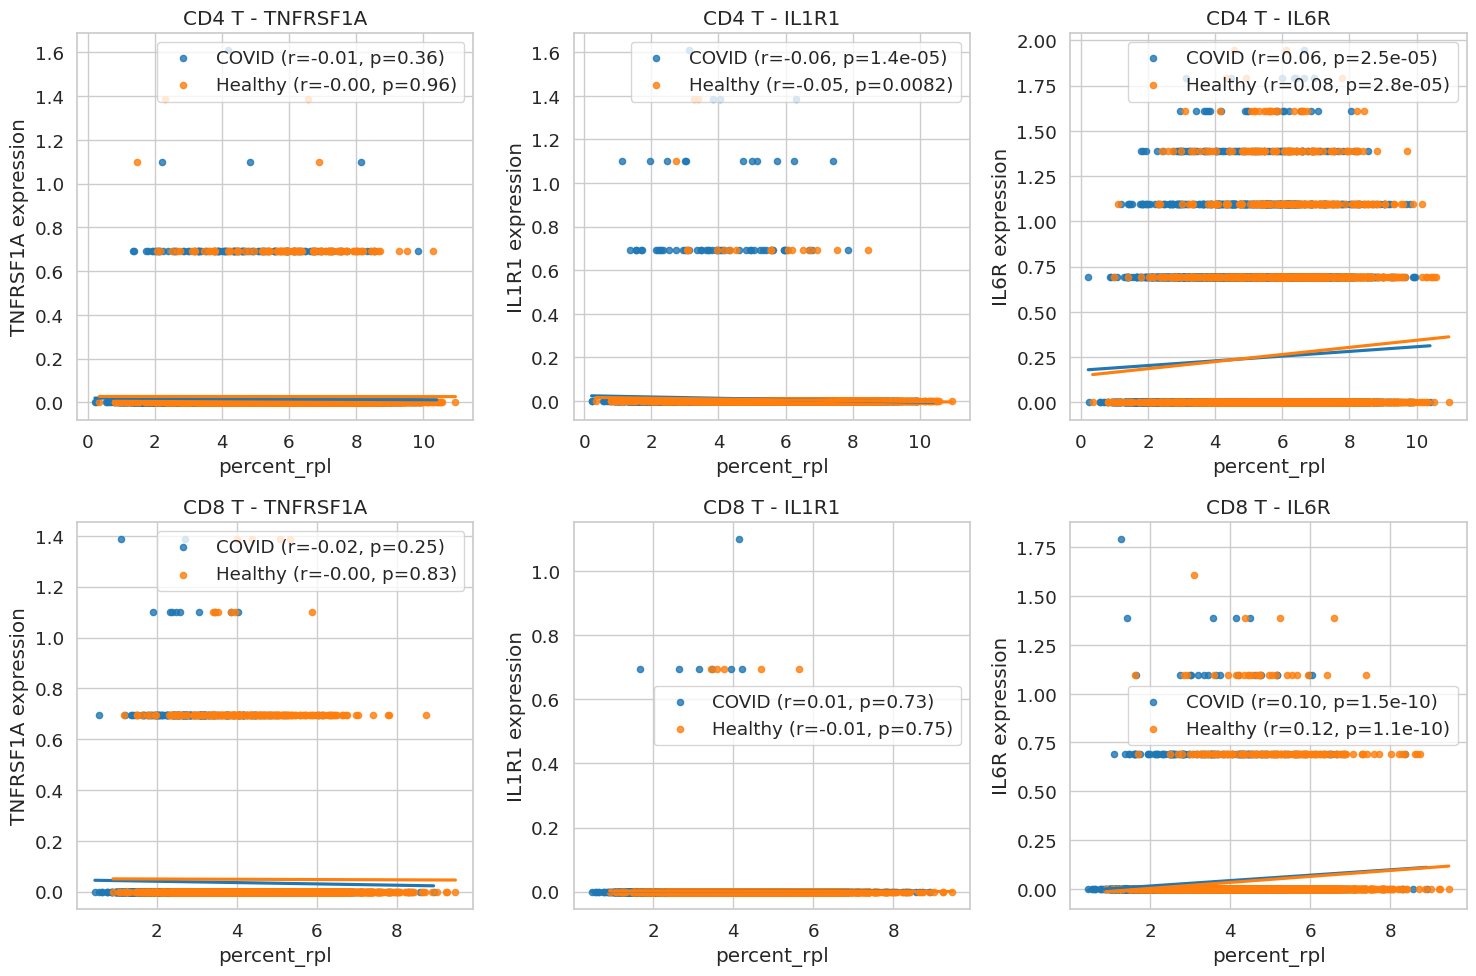

Cell type: CD4 T | Status: COVID | Receptor: TNFRSF1A -> Pearson r: -0.01, raw p-value: 0.36, Bonferroni adjusted p-value: 1
Cell type: CD4 T | Status: Healthy | Receptor: TNFRSF1A -> Pearson r: -0.00, raw p-value: 0.96, Bonferroni adjusted p-value: 1
Cell type: CD4 T | Status: COVID | Receptor: IL1R1 -> Pearson r: -0.06, raw p-value: 1.4e-05, Bonferroni adjusted p-value: 0.00017
Cell type: CD4 T | Status: Healthy | Receptor: IL1R1 -> Pearson r: -0.05, raw p-value: 0.0082, Bonferroni adjusted p-value: 0.099
Cell type: CD4 T | Status: COVID | Receptor: IL6R -> Pearson r: 0.06, raw p-value: 2.5e-05, Bonferroni adjusted p-value: 0.0003
Cell type: CD4 T | Status: Healthy | Receptor: IL6R -> Pearson r: 0.08, raw p-value: 2.8e-05, Bonferroni adjusted p-value: 0.00034
Cell type: CD8 T | Status: COVID | Receptor: TNFRSF1A -> Pearson r: -0.02, raw p-value: 0.25, Bonferroni adjusted p-value: 1
Cell type: CD8 T | Status: Healthy | Receptor: TNFRSF1A -> Pearson r: -0.00, raw p-value: 0.83, Bonferr

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define the cytokine receptor genes of interest
cytokine_receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Subset the AnnData object to T cells using cell_type_coarse
t_cell_types = ['CD4 T', 'CD8 T']
adata_tcells = adata[adata.obs['cell_type_coarse'].isin(t_cell_types)].copy()

# Verify that all cytokine receptor genes are present in the dataset
missing_genes = [gene for gene in cytokine_receptors if gene not in adata_tcells.var_names]
if missing_genes:
    raise ValueError(f"The following cytokine receptor genes are missing in adata.var_names: {missing_genes}")

# Define a helper function to extract gene expression from the anndata object

def get_gene_expression(adata_obj, gene):
    expr = adata_obj[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    return expr

# Create a dataframe from the T cells metadata
df = adata_tcells.obs.copy()

# For each cytokine receptor, extract the expression values and add them as new columns
for gene in cytokine_receptors:
    df[gene] = get_gene_expression(adata_tcells, gene)

# Initialize a list to store correlation analysis results
corr_results = []

# Set up grid for scatter plots: rows = T cell types, columns = cytokine receptors
fig, axes = plt.subplots(nrows=len(t_cell_types), ncols=len(cytokine_receptors), figsize=(5 * len(cytokine_receptors), 5 * len(t_cell_types)))
if len(t_cell_types) == 1 or len(cytokine_receptors) == 1:
    axes = np.atleast_2d(axes)

# Loop over each combination of T cell type and cytokine receptor
for i, cell in enumerate(t_cell_types):
    for j, gene in enumerate(cytokine_receptors):
        subset = df[df['cell_type_coarse'] == cell]
        ax = axes[i, j]
        statuses = subset['Status'].unique()
        for status in statuses:
            status_subset = subset[subset['Status'] == status]
            x = status_subset['percent_rpl']
            y = status_subset[gene]
            if len(x) > 1 and len(y) > 1:
                r, p = pearsonr(x, y)
                # Append raw results; adjust p-value later using Bonferroni correction
                corr_results.append({
                    'cell_type': cell,
                    'Status': status,
                    'cytokine_receptor': gene,
                    'pearson_r': r,
                    'raw_p_value': p
                })
                sns.regplot(x=x, y=y, ax=ax, label=f"{status} (r={r:.2f}, p={p:.2g})", ci=None, scatter_kws={'s': 20})
            else:
                ax.text(0.5, 0.5, f'Insufficient data for {status}', horizontalalignment='center', verticalalignment='center')
        ax.set_title(f"{cell} - {gene}")
        ax.set_xlabel('percent_rpl')
        ax.set_ylabel(f"{gene} expression")
        ax.legend()

plt.tight_layout()
plt.show()

# Apply Bonferroni correction for multiple testing adjustment
n_tests = len(corr_results)
for res in corr_results:
    adjusted_p = min(res['raw_p_value'] * n_tests, 1.0)
    res['adjusted_p_value'] = adjusted_p

# Print correlation analysis results with both raw and adjusted p-values
for res in corr_results:
    print(f"Cell type: {res['cell_type']} | Status: {res['Status']} | Receptor: {res['cytokine_receptor']} -> Pearson r: {res['pearson_r']:.2f}, raw p-value: {res['raw_p_value']:.2g}, Bonferroni adjusted p-value: {res['adjusted_p_value']:.2g}")


### Agent Interpretation

The current analysis shows some potential insights into receptor expression differences between COVID-19 patients and healthy individuals within certain T cell subsets. Here are some key points and suggestions for future steps:

1. **Significant Findings in IL1R1 and IL6R:**
   - **CD4 T Cells:** IL1R1 shows a modest negative correlation in the COVID group, which is statistically significant even after adjustment. IL6R shows a positive correlation in both COVID and healthy groups, with significant p-values after Bonferroni adjustment. The expression of these receptors suggests altered cytokine signaling pathways in COVID patients.
   - **CD8 T Cells:** IL6R shows a significant positive correlation in both groups. This further supports potential dysregulation of cytokine-mediated communication in COVID patients.

2. **Non-significant Findings in TNFRSF1A:**
   - The receptor TNFRSF1A shows no significant correlations for either CD4 or CD8 T cells in both COVID and healthy individuals, suggesting that TNF signaling may not be distinctly altered in these cases within the T cell populations analyzed.

3. **Future Analysis Directions:**
   - **Focus on ILR Receptors:** Given the significant correlations with IL1R1 and IL6R, particularly in CD4 T cells, further literature review and pathway analysis could help elucidate their roles in disease progression or immune modulation in COVID-19.
   - **Broaden Receptor Analysis:** Explore additional inflammatory receptors or signaling pathways, such as other interleukin receptors, to determine if similar patterns of dysregulation are present.
   - **Immune Cell Interaction Exploration:** Using ligand-receptor interaction analyses, investigate how monocyte and T cell interactions might be enhanced, potentially contributing to the immunopathology observed in severe COVID-19.
   - **Subset and Longitudinal Analysis:** Consider more granular sub-clustering of T cells and longitudinal analysis to capture changes over time or therapy impacts.

4. **Distinct Analysis Pathways:**
   - Ensure novelty by extending to cytokine or chemokine receptor analyses outside of the ones already covered in similar studies. This could include investigatory cytokines not commonly focused upon or exploring post-transcriptional regulation differences using integrated datasets.

By following these steps, the analysis can further explore the complexities of immune signaling in COVID-19, enriching the understanding beyond current literature.

## This code subsets the dataset to CD4 T cells, computes a ribosomal ratio metric, and stratifies the cells into high and low receptor expression groups using a median split, followed by statistical testing and visualization. A helper function is added to improve code clarity by handling repetitive plot annotation.

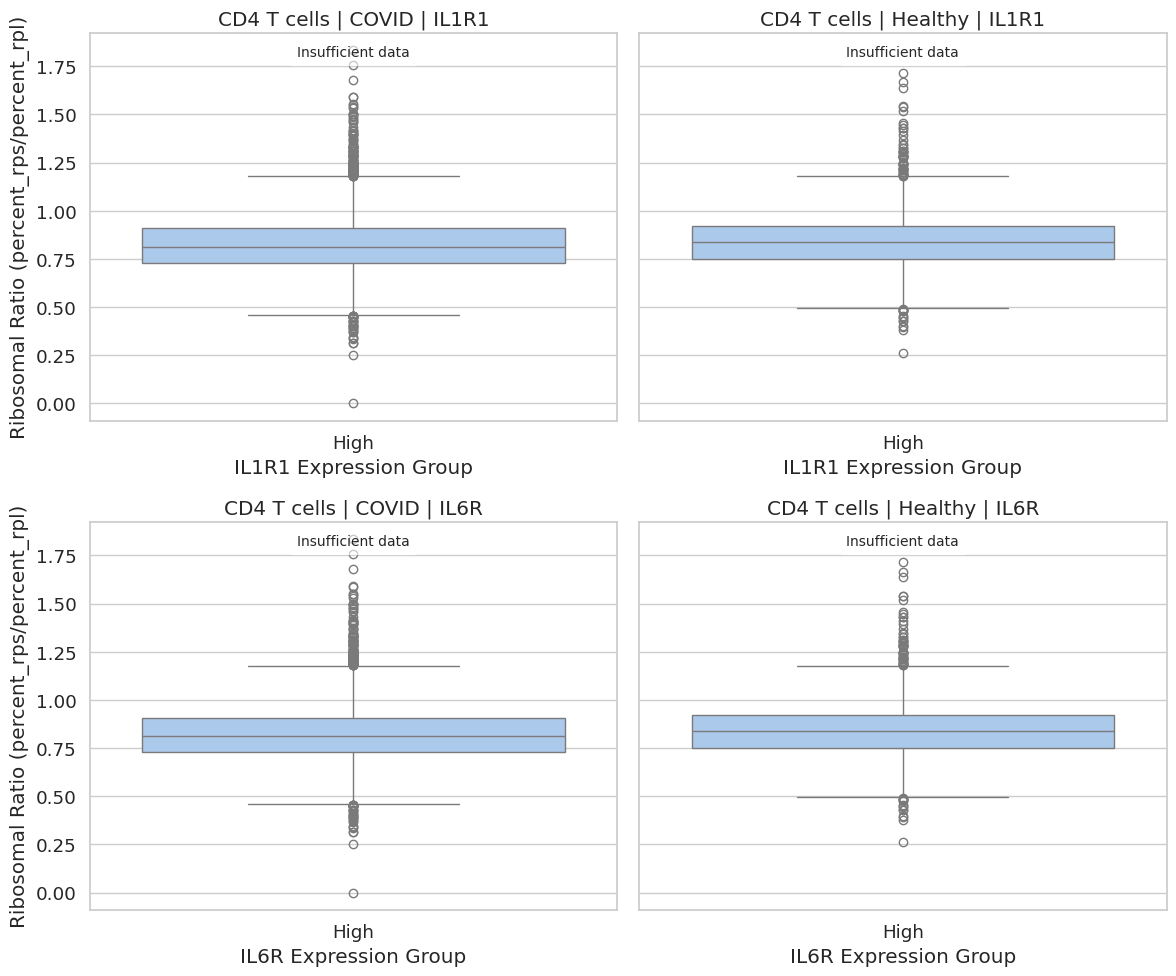

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Subset the AnnData object to focus on CD4 T cells
adata_cd4 = adata[adata.obs['cell_type_coarse'] == 'CD4 T'].copy()

# Create a dataframe from the CD4 T cell metadata for analysis and plotting
df_cd4 = adata_cd4.obs.copy()

# Compute the ribosomal ratio (percent_rps / percent_rpl) for each cell; add a tiny constant to prevent division by zero
df_cd4['ribosomal_ratio'] = df_cd4['percent_rps'] / (df_cd4['percent_rpl'] + 1e-6)

# Define the receptors of interest for further stratification
receptors = ['IL1R1', 'IL6R']

# Extract expression data for each receptor from the AnnData object (handles both dense and sparse matrices) and add to the dataframe
for receptor in receptors:
    expr = adata_cd4[:, receptor].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    df_cd4[receptor] = expr

# Helper function to add annotation text to a plot
def annotate_plot(ax, p_value):
    # Add a text box inside the plot with the Mann-Whitney U test p-value
    ax.text(0.5, 0.95, f"MW p={p_value:.2g}", horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

# Initialize a list to store statistical test results
stat_results = []

# Set up a grid for boxplots: rows correspond to receptors and columns correspond to Status groups
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Loop through each receptor and Status group
for i, receptor in enumerate(receptors):
    # Stratify cells into High/Low groups based on the median expression of the receptor
    median_expr = df_cd4[receptor].median()
    df_cd4[receptor + '_group'] = np.where(df_cd4[receptor] >= median_expr, 'High', 'Low')
    
    for j, status in enumerate(['COVID', 'Healthy']):
        ax = axes[i, j]
        subset = df_cd4[df_cd4['Status'] == status]
        
        # Create boxplot of ribosomal ratio by receptor expression group
        sns.boxplot(x=receptor + '_group', y='ribosomal_ratio', data=subset, ax=ax, palette='pastel')
        ax.set_title(f"CD4 T cells | {status} | {receptor}")
        ax.set_xlabel(f"{receptor} Expression Group")
        ax.set_ylabel("Ribosomal Ratio (percent_rps/percent_rpl)")
        
        # Retrieve data for statistical testing
        group_high = subset[subset[receptor + '_group'] == 'High']['ribosomal_ratio']
        group_low = subset[subset[receptor + '_group'] == 'Low']['ribosomal_ratio']
        
        # Only perform the Mann-Whitney U test if both groups have sufficient data
        if len(group_high) > 0 and len(group_low) > 0:
            u_stat, p_val = mannwhitneyu(group_high, group_low, alternative='two-sided')
            stat_results.append({
                'receptor': receptor,
                'Status': status,
                'mannwhitney_u': u_stat,
                'p_value': p_val
            })
            annotate_plot(ax, p_val)  # use helper to annotate plot with test statistics
        else:
            ax.text(0.5, 0.95, "Insufficient data", horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

# Print the statistical test results
for res in stat_results:
    print(f"{res['receptor']} | Status: {res['Status']} -> Mann-Whitney U: {res['mannwhitney_u']:.2f}, p = {res['p_value']:.2g}")

### Agent Interpretation

The current analysis investigates the expression of IL1R1 and IL6R receptors in CD4 T cells from COVID-19 patients compared to healthy controls, focusing on their relationship with ribosomal content. The preliminary boxplots compare ribosomal ratios in groups with high receptor expression.

### Feedback and Suggestions:

1. **Promising Aspects:**
   - The focus on IL1R1 and IL6R aligns well with the hypothesis about dysregulated communication in severe COVID-19, targeting CD4 T cell receptor expression.

2. **Data Limitation:**
   - There seems to be insufficient data for meaningful comparisons, as noted by the "insufficient data" remarks. Assess whether you can obtain additional samples or merge data across similar studies for increased power.

3. **Biological Insights:**
   - Investigate whether high IL1R1 and IL6R expression correlates with altered ribosomal content and potential T cell activation or exhaustion states. This may help link receptor upregulation with functional alterations in COVID-19.

4. **Further Analysis:**
   - **Gene Correlation:** Analyze correlations between IL1R1/IL6R expression and other key inflammatory genes or immune markers within CD4 T cells.
   - **Pathway Enrichment:** Conduct pathway enrichment analyses to explore broader signaling alterations associated with high IL1R1/IL6R expression levels.
   - **Cell-Cell Communication:** Use complementary tools, such as CellPhoneDB, to examine ligand-receptor interactions between monocytes and T cells, focusing on potential mechanistic drivers of immunopathology.
   - **Additional Variables:** Consider subdividing patient groups by disease severity or clinical features to identify specific contexts where communication alteration is most pronounced.

5. **Iterative Approach:**
   - Reflect on variable aspects such as normalization or selection criteria to ensure robustness. Consider both biological replicates and technical variance to fine-tune analysis criteria.

This multi-step approach can provide a clearer understanding of how receptor expression impacts CD4 T cells in severe COVID-19 and potentially uncover new therapeutic targets.

## This code first subsets CD4 T cells, computes the ribosomal ratio and extracts gene expression for receptors and activation markers. It then creates boxplots comparing marker expression between high and low receptor expression groups stratified by disease status, and constructs updated scatter plots that further stratify the correlation analysis by both receptor expression group (High vs Low) and disease status.

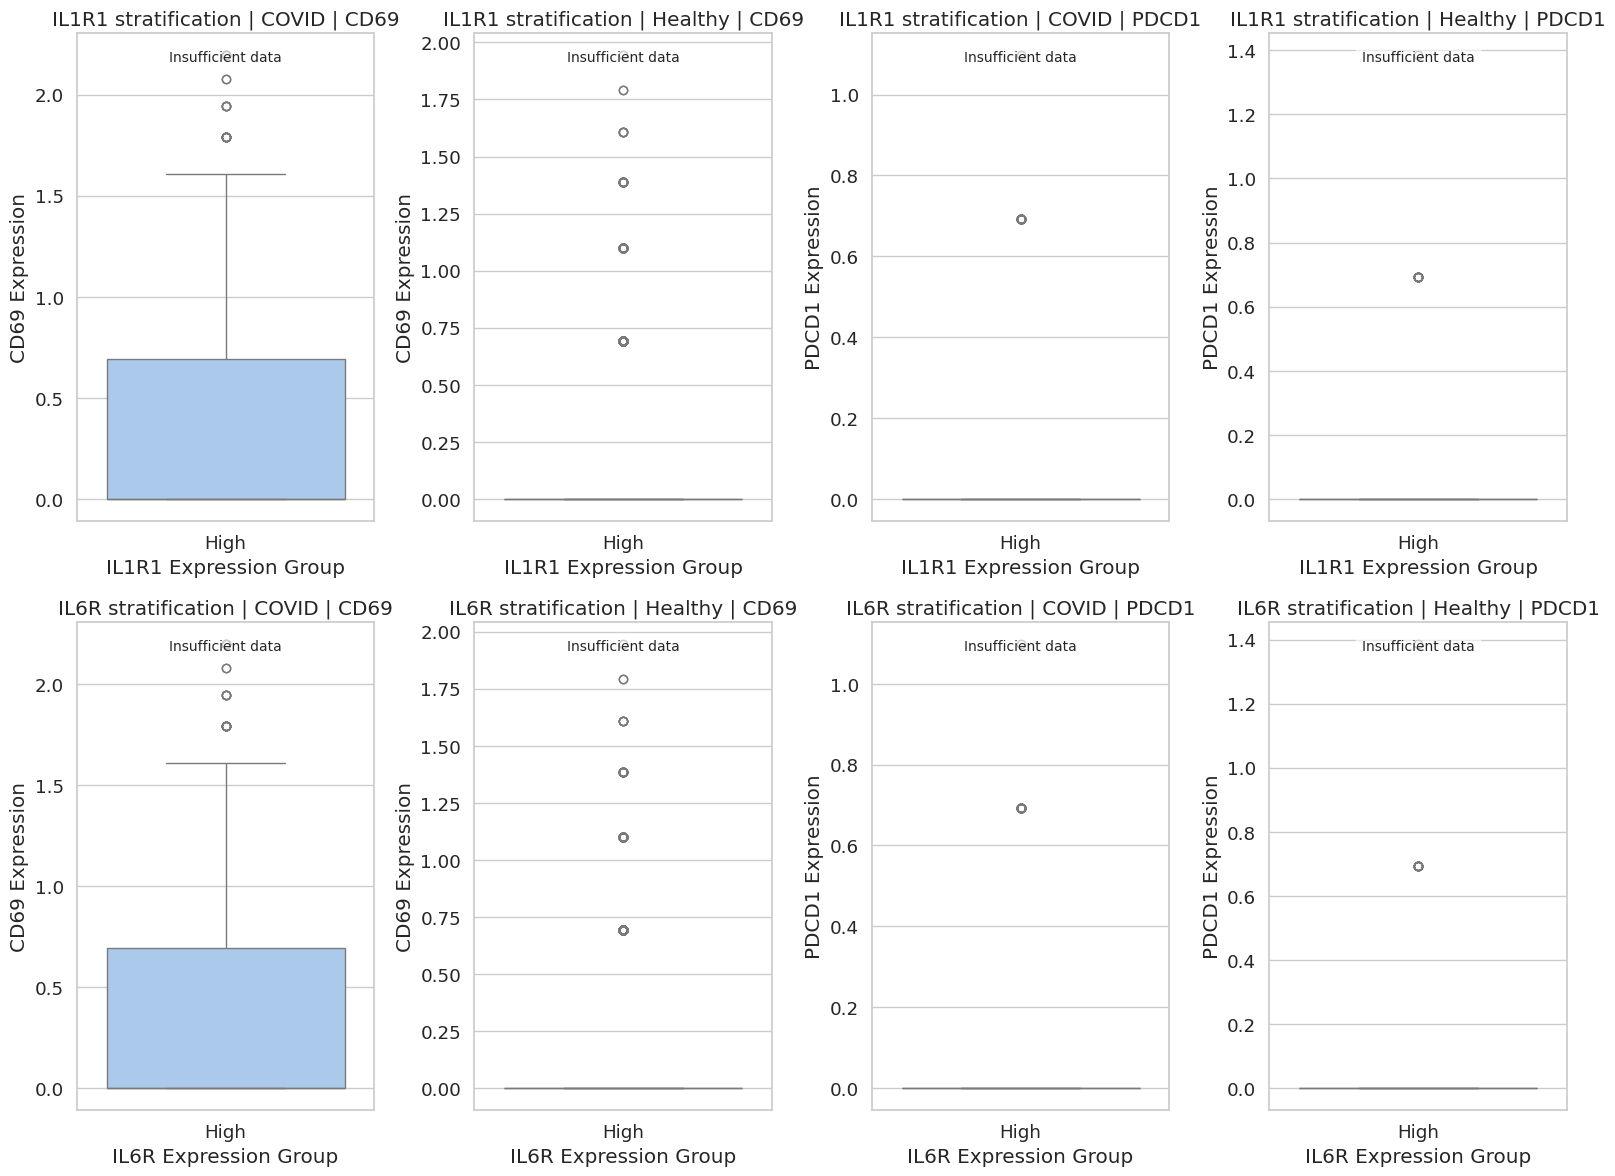

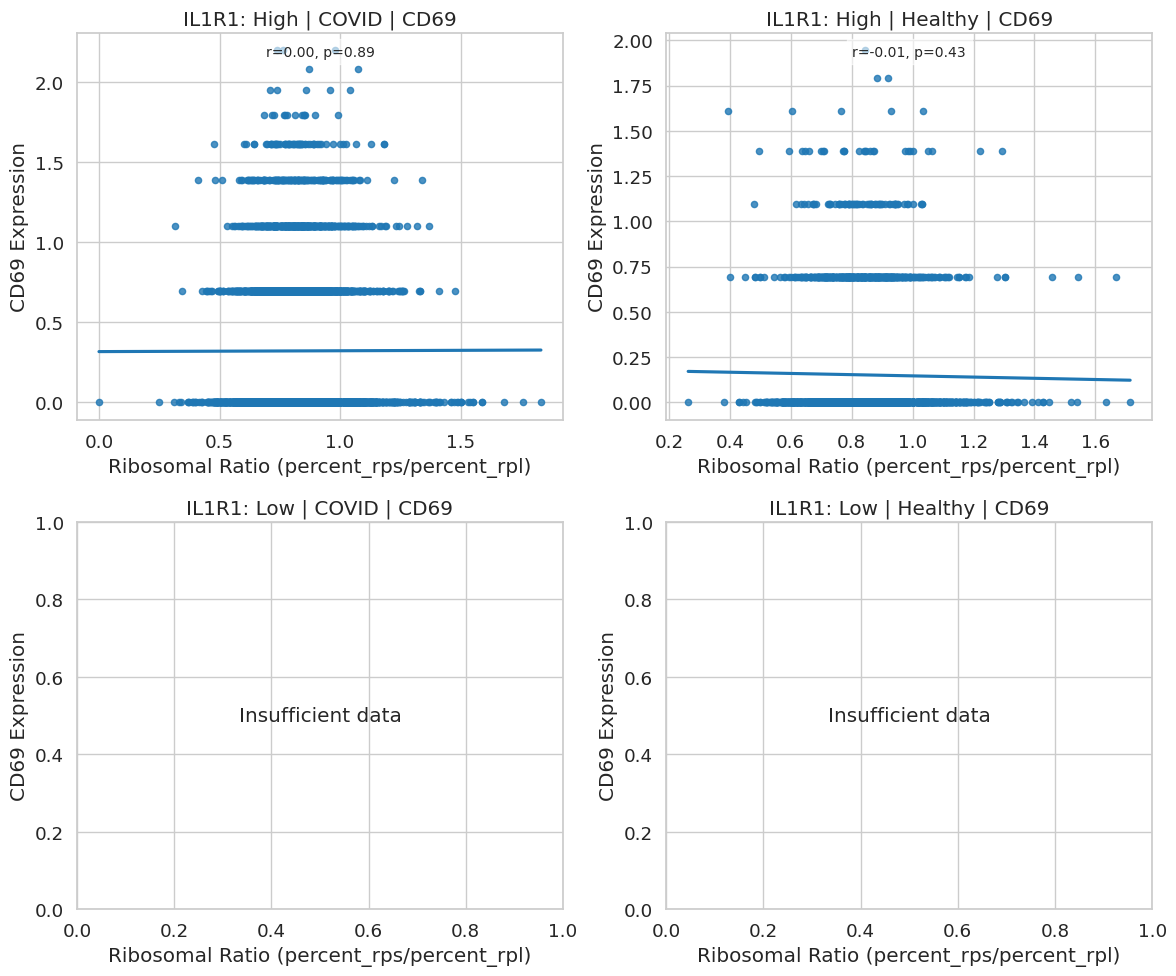

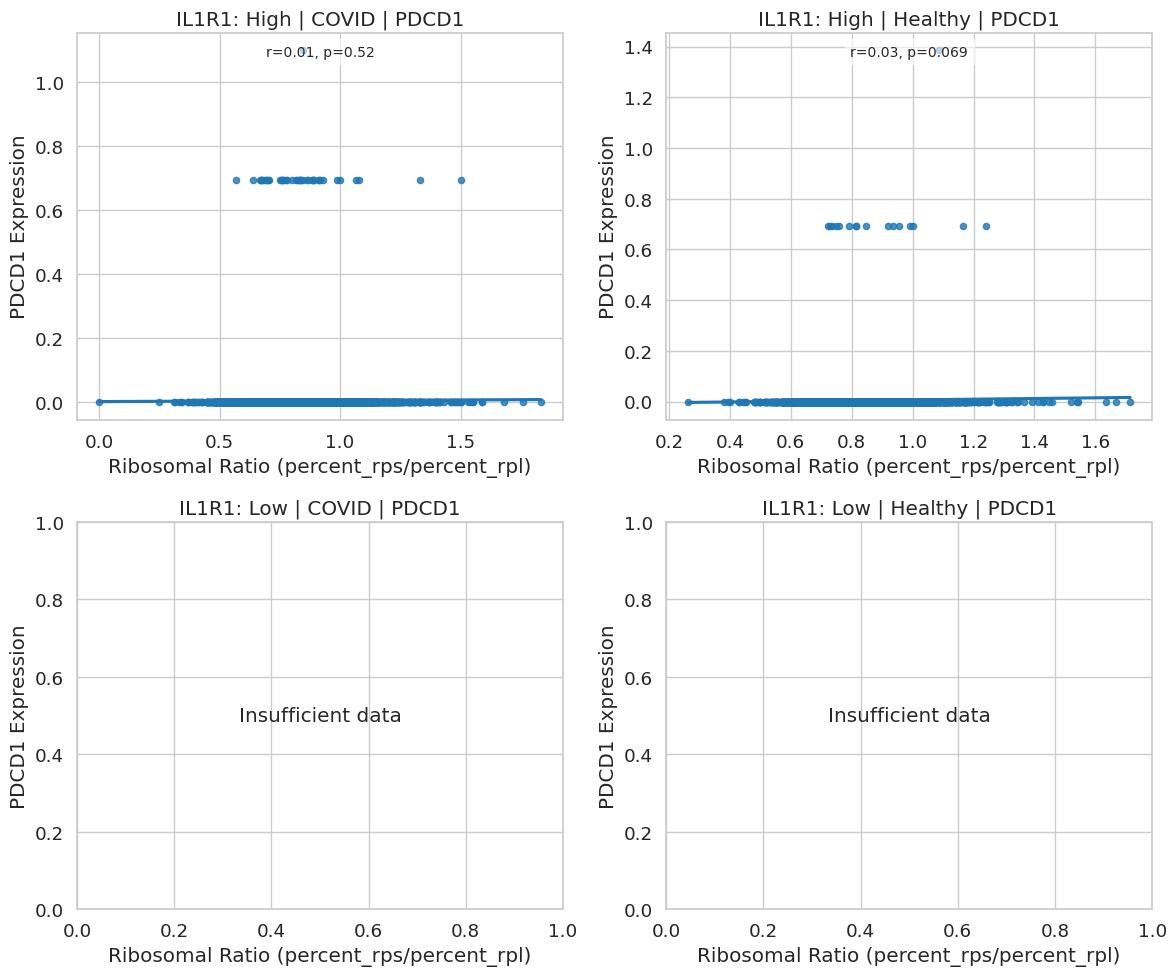

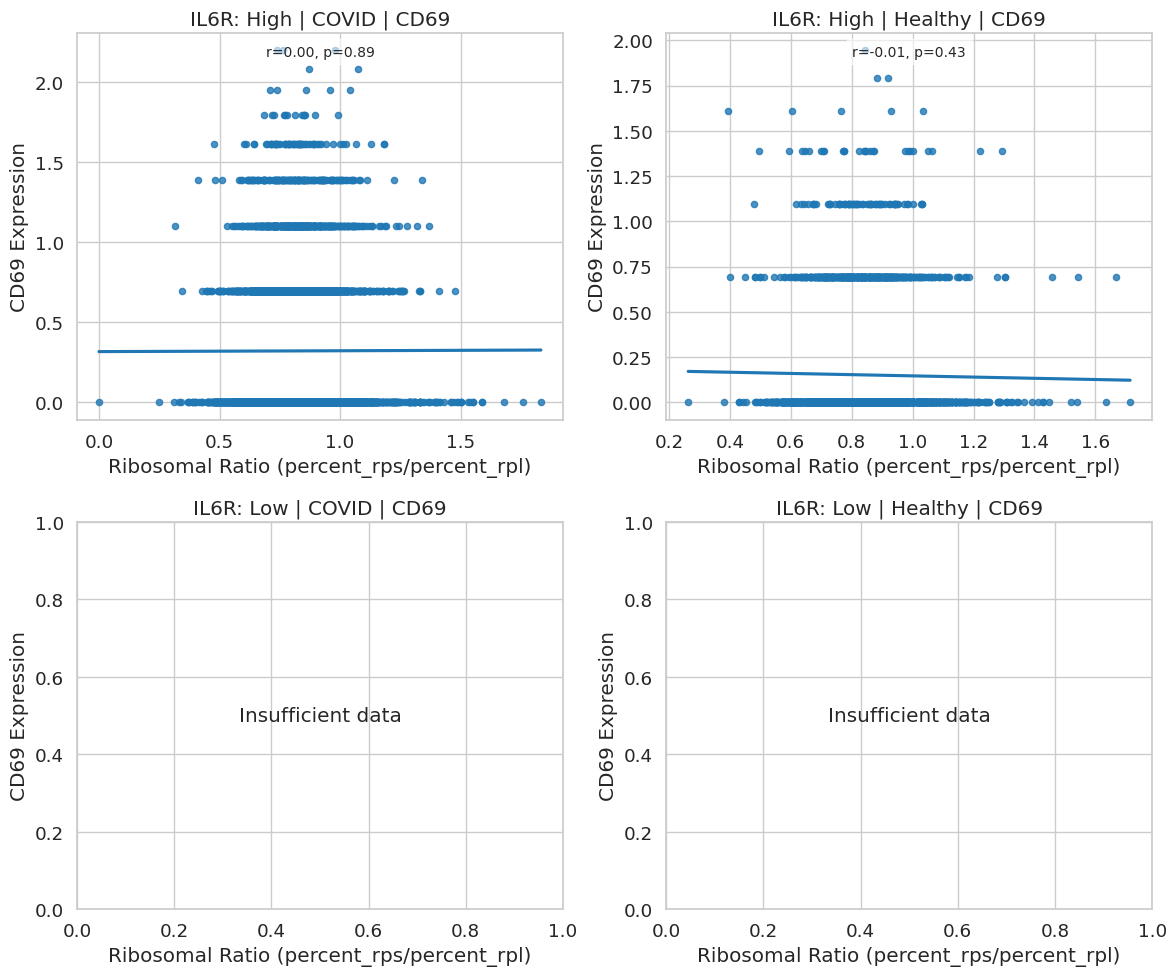

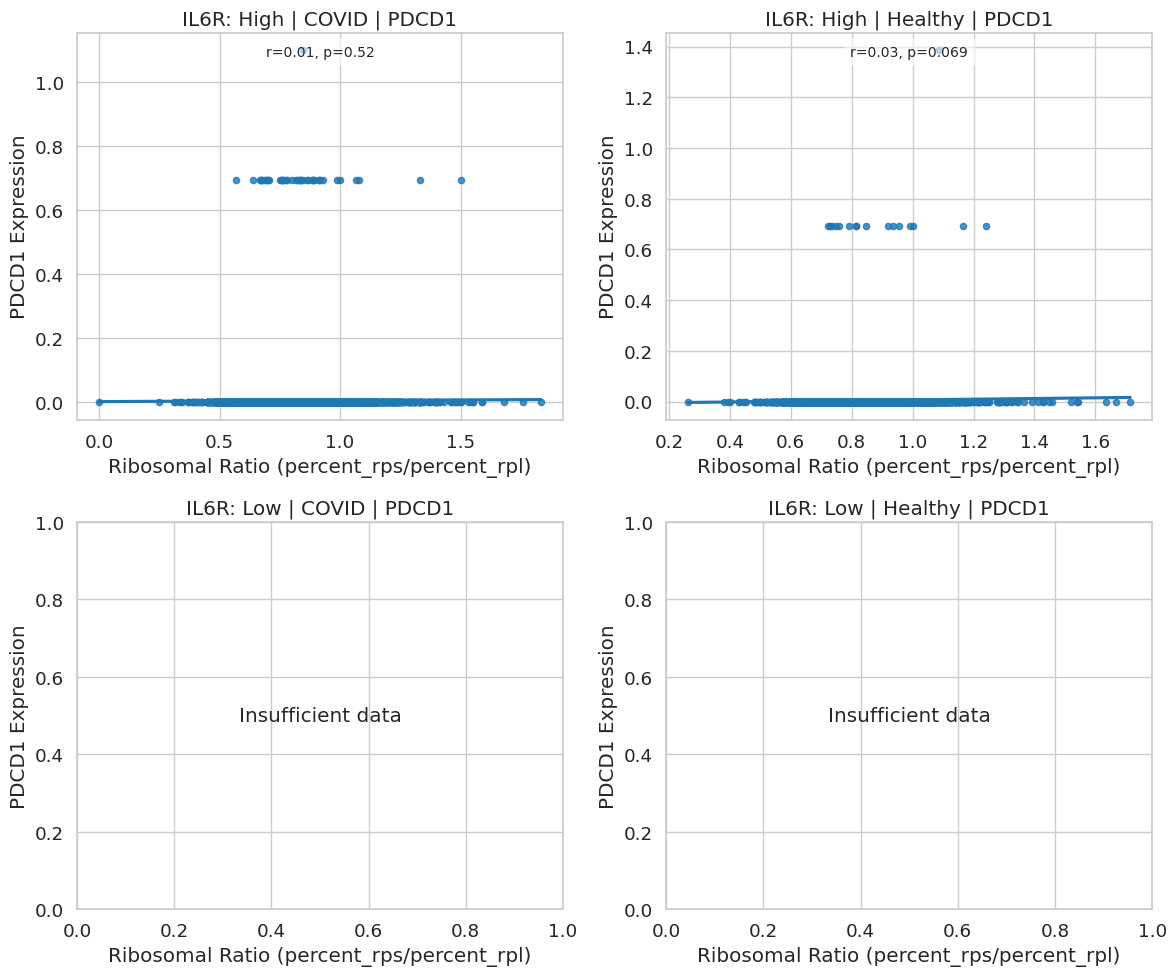

In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pearsonr

# Subset the AnnData object to CD4 T cells and create a working dataframe
adata_cd4 = adata[adata.obs['cell_type_coarse'] == 'CD4 T'].copy()
df_cd4 = adata_cd4.obs.copy()

# Compute ribosomal ratio (percent_rps / percent_rpl) with a small constant to avoid division by zero
df_cd4['ribosomal_ratio'] = df_cd4['percent_rps'] / (df_cd4['percent_rpl'] + 1e-6)

# Define receptors and activation/exhaustion markers
receptors = ['IL1R1', 'IL6R']
markers = ['CD69', 'PDCD1']

# Helper function to extract gene expression (handles both sparse and dense matrices)
def get_gene_expression(adata_obj, gene):
    expr = adata_obj[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    return expr

# Extract expression data for each receptor and marker; raise error if gene is missing
for gene in receptors + markers:
    if gene not in adata_cd4.var_names:
        raise ValueError(f"Gene {gene} is missing in the dataset")
    df_cd4[gene] = get_gene_expression(adata_cd4, gene)

# ----- Boxplots: Compare activation markers between High/Low receptor groups within each Status -----
# Set up figure for boxplots; rows = receptors, columns = (COVID, Healthy) for each marker
fig, axes = plt.subplots(nrows=len(receptors), ncols=len(markers)*2, figsize=(16, 6*len(receptors)))

for i, receptor in enumerate(receptors):
    # Stratify cells based on the median expression of the receptor
    median_expr = df_cd4[receptor].median()
    group_col = receptor + '_group'
    df_cd4[group_col] = np.where(df_cd4[receptor] >= median_expr, 'High', 'Low')
    
    for j, marker in enumerate(markers):
        # For each disease Status separately
        for k, status in enumerate(['COVID', 'Healthy']):
            ax = axes[i, j*2 + k]
            subset = df_cd4[df_cd4['Status'] == status]
            sns.boxplot(x=group_col, y=marker, data=subset, ax=ax, palette='pastel')
            ax.set_title(f"{receptor} stratification | {status} | {marker}")
            ax.set_xlabel(f"{receptor} Expression Group")
            ax.set_ylabel(f"{marker} Expression")
            
            # Perform Mann-Whitney U test if both groups have data
            group_high = subset[subset[group_col]=='High'][marker]
            group_low = subset[subset[group_col]=='Low'][marker]
            if len(group_high) > 0 and len(group_low) > 0:
                u_stat, p_val = mannwhitneyu(group_high, group_low, alternative='two-sided')
                ax.text(0.5, 0.95, f"MW p={p_val:.2g}", horizontalalignment='center', verticalalignment='center', 
                        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
            else:
                ax.text(0.5, 0.95, "Insufficient data", horizontalalignment='center', verticalalignment='center', 
                        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

# ----- Scatter Plots: Correlate ribosomal ratio with activation markers, stratified by receptor group and disease Status -----
# For each receptor and each activation marker, create a 2x2 grid where rows are receptor groups (High, Low) and columns are Status (COVID, Healthy)
for receptor in receptors:
    group_col = receptor + '_group'
    # Ensure the receptor stratification already exists
    if group_col not in df_cd4.columns:
        median_expr = df_cd4[receptor].median()
        df_cd4[group_col] = np.where(df_cd4[receptor] >= median_expr, 'High', 'Low')
    
    for marker in markers:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
        # Create mapping for subplot positions
        group_order = ['High', 'Low']
        status_order = ['COVID', 'Healthy']
        
        for i, grp in enumerate(group_order):
            for j, status in enumerate(status_order):
                ax = axes[i, j]
                subset = df_cd4[(df_cd4[group_col] == grp) & (df_cd4['Status'] == status)]
                x = subset['ribosomal_ratio']
                y = subset[marker]
                
                if len(x) > 1 and len(y) > 1:
                    r, p = pearsonr(x, y)
                    sns.regplot(x=x, y=y, ax=ax, ci=None, scatter_kws={'s':20})
                    ax.text(0.5, 0.95, f"r={r:.2f}, p={p:.2g}", horizontalalignment='center', verticalalignment='center', 
                            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
                else:
                    ax.text(0.5, 0.5, 'Insufficient data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f"{receptor}: {grp} | {status} | {marker}")
                ax.set_xlabel('Ribosomal Ratio (percent_rps/percent_rpl)')
                ax.set_ylabel(f"{marker} Expression")
        
        plt.tight_layout()
        plt.show()

### Agent Interpretation

The current analysis appears to investigate the expression of CD69 and PDCD1 in T cells stratified by high expression of IL1R1 and IL6R, both in COVID-19 patients and healthy controls. The data highlights potential differences in expression patterns, yet faces limitations due to insufficient data in some expression groups and variables. Here are some suggestions for the next steps:

1. **Increase Sample Size**: The results show "insufficient data" for many conditions, particularly for COVID-19 patients with low IL1R1/IL6R expression. Increasing the sample size could help achieve more statistically robust results and improve the power of the analysis.

2. **Focus on Significant Clusters**: The observations where there is a notable difference between COVID-19 and healthy controls, even if not statistically significant yet, should be investigated further. Consider increasing granularity in clustering to pinpoint specific subtypes showing these differences.

3. **Expand Marker Analysis**: Since the hypothesis involves communication pathways, consider expanding the set of receptor-ligand markers beyond IL1R1/IL6R and their targets. Evaluate other cytokine pathways previously implicated in cytokine storms and severe COVID-19 progression.

4. **Correlation with Clinical Data**: Integrate expression data with clinical metadata, such as ARDS status or ventilation requirement, to determine if expression patterns correlate with disease severity or outcomes.

5. **Alternative Methods for Validation**: Consider validating the computational findings with experimental techniques such as flow cytometry or ELISA to measure protein levels and cell surface markers.

6. **Temporal Dynamics**: Investigate temporal changes in receptor-ligand interactions or expression in severe COVID-19 cases across the course of illness. This might reveal more about the dynamics of immune dysregulation.

7. **Investigate Cell-Cell Interactions**: Utilize cell-cell communication inference tools (e.g., CellChat, NicheNet) to explore potential signaling pathways and networks beyond simple receptor-ligand interactions, which could elucidate complex intercellular communication changes.

By addressing data limitations and diversifying the analytical approach, you can gain deeper insights into the mechanisms underpinning immune responses in severe COVID-19.

## This code subsets the AnnData object to include only CD4 and CD8 T cells, verifies the distributions of COVID Status and Ventilated columns, and creates violin plots with overlaid strip plots for percent_rpl and percent_rps. The changes (removing split=True) improve visualization accuracy for the multi-level Ventilated variable.

Status counts in T cells:
Status
COVID      9439
Healthy    5720
Name: count, dtype: int64
Ventilation status counts in T cells:
Ventilated
Vent       6551
Healthy    5720
NonVent    2888
Name: count, dtype: int64


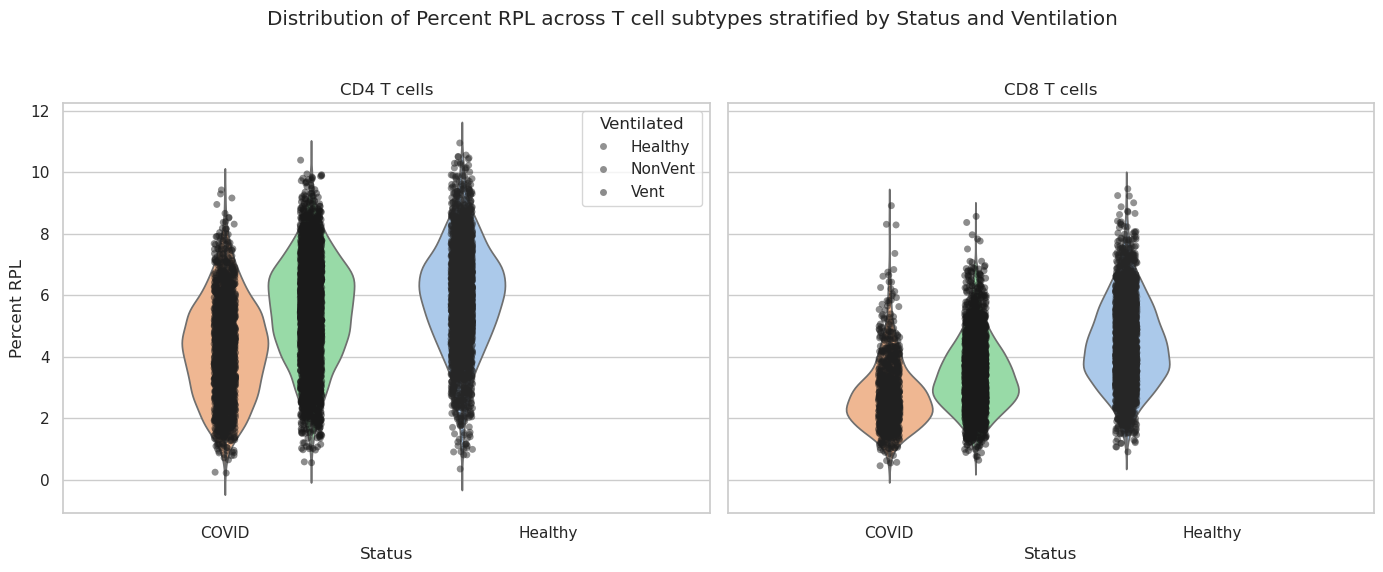

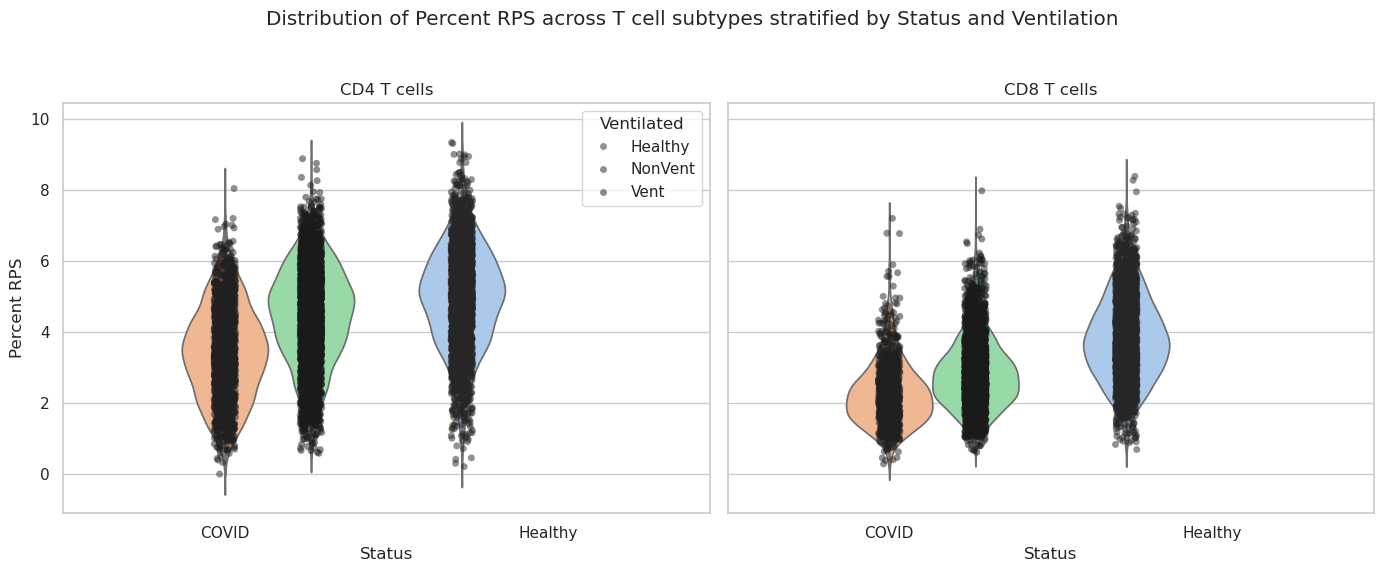

In [7]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Subset the AnnData object to focus on T cells (CD4 T and CD8 T)
t_cell_types = ['CD4 T', 'CD8 T']
adata_tcells = adata[adata.obs['cell_type_coarse'].isin(t_cell_types)].copy()

# Create a DataFrame from the T cell metadata
df = adata_tcells.obs.copy()

# Check the unique levels for Status and Ventilated for stratification
print('Status counts in T cells:')
print(df['Status'].value_counts())

print('Ventilation status counts in T cells:')
print(df['Ventilated'].value_counts())

# Set the plotting style
sns.set(style='whitegrid')

# Define a function to generate violin plots with overlaid strip plots
# Note: removed split=True because the 'Ventilated' variable has more than two levels

def plot_ribosomal_metric(metric, ylabel):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
    
    # Loop through cell types separately
    for i, cell_type in enumerate(t_cell_types):
        subset = df[df['cell_type_coarse'] == cell_type]
        ax = axes[i]
        
        # Plot violin plot stratified by Status and use Ventilated as hue
        sns.violinplot(x='Status', y=metric, hue='Ventilated', data=subset, ax=ax, palette='pastel')
        
        # Overlay strip plot for individual cell data
        sns.stripplot(x='Status', y=metric, hue='Ventilated', data=subset, ax=ax, dodge=True, color='k', alpha=0.5, jitter=True)
        
        # Handle duplicate legends: only display legend in the first subplot
        handles, labels = ax.get_legend_handles_labels()
        if i == 0:
            # Deduplicate legend entries
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), title='Ventilated')
        else:
            ax.legend_.remove()

        ax.set_title(f"{cell_type} cells")
        ax.set_xlabel('Status')
        ax.set_ylabel(ylabel)
        
    plt.suptitle(f"Distribution of {ylabel} across T cell subtypes stratified by Status and Ventilation")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot for percent_rpl
plot_ribosomal_metric('percent_rpl', 'Percent RPL')

# Plot for percent_rps
plot_ribosomal_metric('percent_rps', 'Percent RPS')


### Agent Interpretation

The results provided offer a snapshot of how ribosomal protein expression (percent RPL and RPS) varies across CD4 and CD8 T cell subtypes stratified by COVID status and ventilation. Here are some avenues for further analysis:

1. **Detailed Statistical Analysis**:
   - Perform statistical tests (e.g., ANOVA or Kruskal-Wallis) to determine if differences in ribosomal protein expression between groups are statistically significant.

2. **Explore Biological Implications**:
   - Investigate if changes in ribosomal protein gene (RPL and RPS) expression correlate with T cell functionality or exhaustion, as ribosomal proteins can be linked to protein synthesis and cellular stress responses.

3. **Integrate with Existing Hypotheses**:
   - Examine any potential links between increased/decreased RPL and RPS expression and enhanced monocyte-T cell signaling, as initially hypothesized. This can be coupled with receptor-ligand interaction analysis.

4. **Correlation with Clinical Outcomes**:
   - Check if variations in ribosomal gene expression correlate with clinical severity or outcomes in patients, particularly focusing on ventilated vs. non-ventilated groups.

5. **Further Subsetting and Analysis**:
   - Further subset the T cells into more specific phenotypes (e.g., memory T cells, regulatory T cells) to assess if ribosomal protein expression differs across subsets within disease categories.

6. **Comparative Pathway Analysis**:
   - Conduct pathway enrichment analysis to see if altered ribosomal protein gene expression is linked with differential pathway activations that are known to be critical in COVID-19 pathology.

7. **Longitudinal or Temporal Analysis**:
   - If longitudinal data is available, observe changes over time in ribosomal protein expression to understand if these shifts are consistent with disease progression or response to treatment.

These steps could help connect the observed transcriptomic changes to the immune dysregulation and pathophysiology of COVID-19, thereby offering insights into potential therapeutic targets or biomarkers.

## This code first subsets the T cell data (CD4 T and CD8 T) and removes potential outlier cells based on extreme z-scores in ribosomal metrics. It then computes Pearson correlation coefficients between percent_rpl and percent_rps for each cell type and Status group, applies Fisher's Z transformation, performs a Fisher Z test to compare groups, and visualizes the results with annotated scatter plots.

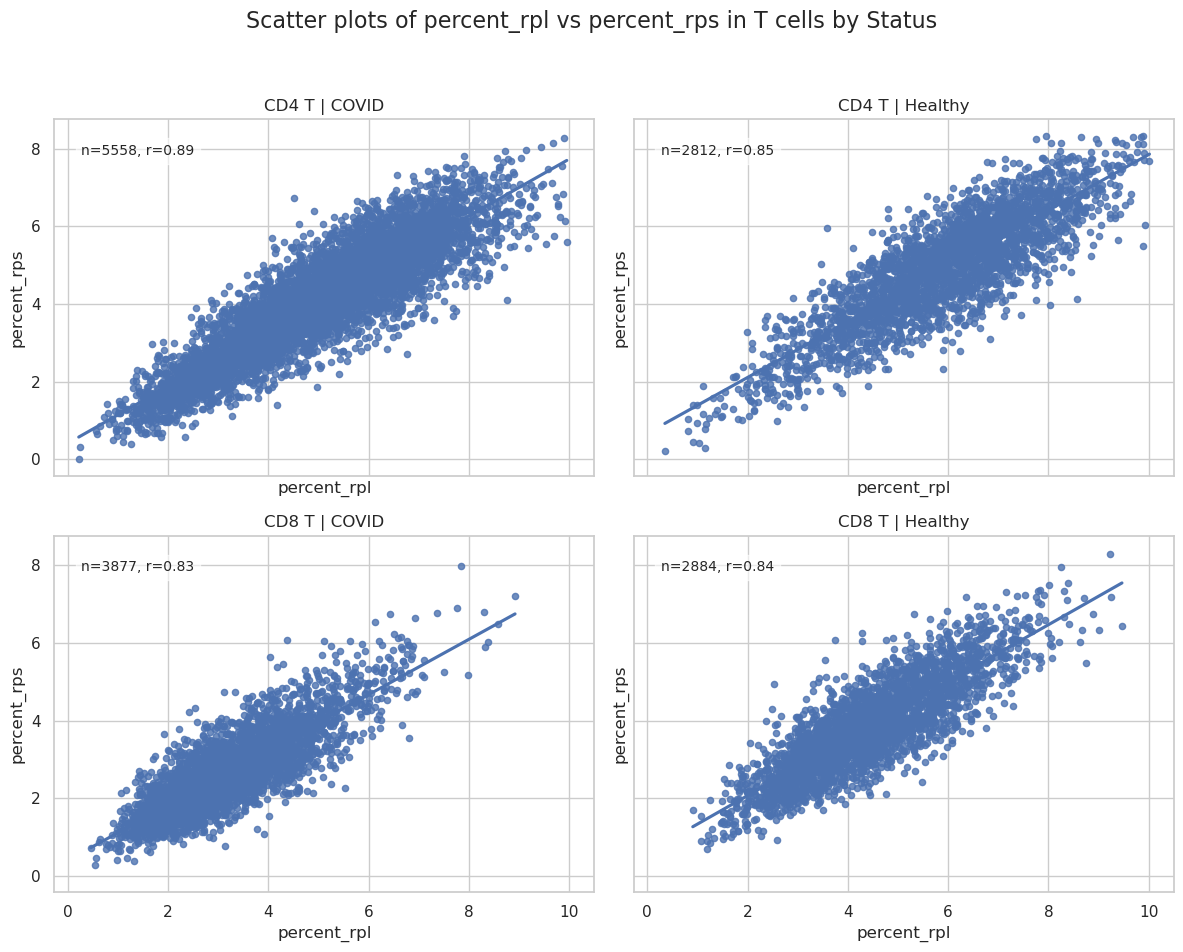

Correlation results for each cell type and Status:
CD4 T | COVID -> n=5558, Pearson r=0.89, raw p-value=0
CD4 T | Healthy -> n=2812, Pearson r=0.85, raw p-value=0
CD8 T | COVID -> n=3877, Pearson r=0.83, raw p-value=0
CD8 T | Healthy -> n=2884, Pearson r=0.84, raw p-value=0

Fisher Z test comparing COVID vs Healthy for each T cell type:
CD4 T -> Z diff=6.43, p-value=1.29e-10
CD8 T -> Z diff=-1.95, p-value=0.0517


In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm

# Subset the AnnData object to T cells (CD4 T and CD8 T) and create a DataFrame from the metadata
cell_types = ['CD4 T', 'CD8 T']
adata_tcells = adata[adata.obs['cell_type_coarse'].isin(cell_types)].copy()
df = adata_tcells.obs.copy()

# Optional Preprocessing: Remove potential outlier cells based on percent_rpl and percent_rps using a z-score threshold
for metric in ['percent_rpl', 'percent_rps']:
    df[metric + '_z'] = (df[metric] - df[metric].mean()) / df[metric].std()

# Filter out cells with absolute z-score greater than 3 for either metric
df = df[(df['percent_rpl_z'].abs() < 3) & (df['percent_rps_z'].abs() < 3)]

# Function to compute Fisher Z transformation
def fisher_z(r):
    # Clip r to avoid infinite values
    r = np.clip(r, -0.9999, 0.9999)
    return 0.5 * np.log((1 + r) / (1 - r))

# Dictionary to store correlations and sample sizes
results = {}

# Loop over each T cell type and Status group
for cell in cell_types:
    results[cell] = {}
    for status in ['COVID', 'Healthy']:
        subset = df[(df['cell_type_coarse'] == cell) & (df['Status'] == status)]
        x = subset['percent_rpl'].values
        y = subset['percent_rps'].values
        n = len(subset)
        if n > 3:  # require at least 4 samples to apply Fisher's method
            r, p_val = pearsonr(x, y)
            results[cell][status] = {'r': r, 'n': n, 'p_raw': p_val, 'z': fisher_z(r)}
        else:
            results[cell][status] = {'r': np.nan, 'n': n, 'p_raw': np.nan, 'z': np.nan}

# For each cell type, perform Fisher's Z test comparing COVID vs Healthy if both groups have sufficient data
fisher_test_results = {}
for cell in cell_types:
    if 'COVID' in results[cell] and 'Healthy' in results[cell]:
        r1 = results[cell]['COVID']['r']
        r2 = results[cell]['Healthy']['r']
        n1 = results[cell]['COVID']['n']
        n2 = results[cell]['Healthy']['n']
        if n1 > 3 and n2 > 3 and not np.isnan(r1) and not np.isnan(r2):
            z1 = results[cell]['COVID']['z']
            z2 = results[cell]['Healthy']['z']
            # Standard error for difference
            se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
            z_diff = (z1 - z2) / se
            p_diff = 2 * (1 - norm.cdf(np.abs(z_diff)))
            fisher_test_results[cell] = {'z_diff': z_diff, 'p_diff': p_diff}
        else:
            fisher_test_results[cell] = {'z_diff': np.nan, 'p_diff': np.nan}

# Plot scatter plots with regression lines for each T cell type and Status
fig, axes = plt.subplots(nrows=len(cell_types), ncols=2, figsize=(12, 5*len(cell_types)), sharex=True, sharey=True)

for i, cell in enumerate(cell_types):
    for j, status in enumerate(['COVID', 'Healthy']):
        ax = axes[i, j] if len(cell_types) > 1 else axes[j]
        subset = df[(df['cell_type_coarse'] == cell) & (df['Status'] == status)]
        sns.regplot(x='percent_rpl', y='percent_rps', data=subset, ax=ax, ci=None, scatter_kws={'s': 20}, color='b')
        ax.set_title(f"{cell} | {status}")
        ax.set_xlabel('percent_rpl')
        ax.set_ylabel('percent_rps')
        n = len(subset)
        if n > 3:
            r = results[cell][status]['r']
            ax.text(0.05, 0.9, f"n={n}, r={r:.2f}", transform=ax.transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6))
        else:
            ax.text(0.05, 0.9, "Insufficient data", transform=ax.transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6))

plt.suptitle('Scatter plots of percent_rpl vs percent_rps in T cells by Status', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the computed correlation results and Fisher Z test results
print('Correlation results for each cell type and Status:')
for cell in results:
    for status in results[cell]:
        res = results[cell][status]
        print(f"{cell} | {status} -> n={res['n']}, Pearson r={res['r']:.2f}, raw p-value={res['p_raw']:.3g}")

print('\nFisher Z test comparing COVID vs Healthy for each T cell type:')
for cell in fisher_test_results:
    res = fisher_test_results[cell]
    print(f"{cell} -> Z diff={res['z_diff']:.2f}, p-value={res['p_diff']:.3g}")

### Agent Interpretation

The results show strong correlations between percent_rpl and percent_rps in both CD4 and CD8 T cells across COVID-19 and healthy groups, with Pearson correlation coefficients near 0.85-0.89. The Fisher Z test indicates a significant difference for CD4 T cells between COVID-19 and healthy controls (p-value = 1.29e-10) but not for CD8 T cells (p-value = 0.0517).

### Feedback:

1. **Promising Results:**
   - The significant correlation differences in CD4 T cells between COVID-19 and healthy controls suggest potential dysregulation related to the COVID-19 status. This aligns with broader research goals looking at immune cell reconfiguration during severe COVID-19.

2. **Further Analysis:**
   - **Pathway Analysis:** Explore if changes in protein synthesis (indicative of rpl and rps percentages) in CD4 T cells correlate with immune responses or cytokine production by performing pathway enrichment analysis.
   - **Gene Expression Changes:** Assess differential expression of genes related to protein synthesis between COVID-19 and healthy controls to further validate translational changes during infection.
   - **Interaction Studies:** Since the hypothesis suggests enhanced communication between monocytes and T cells, look for co-expression networks or ligand-receptor interactions that might be influenced by or influence rpl and rps expression.

3. **Future Directions:**
   - **Comparative Studies:** Establish if similar trends are observed in other immune cell types beyond T cells (e.g., monocytes or NK cells), which would contribute to understanding overall immune dysregulation.
   - **Longitudinal Data:** Analyze time-course data if available to understand how these correlations change over the course of the disease.

4. **Validation:**
   - Use additional datasets or experimental approaches to validate the findings, ensuring that the alterations observed in ribosomal component expression (rpl and rps) are reproducible and biologically significant.

These follow-ups can provide insights into the impact of COVID-19 on immune cell protein synthesis and possibly connect these findings to broader immune responses.